### Explanatiory Data Analysis

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import plotly.express as px
import seaborn as sns
import numpy as np

In [47]:
data_path = Path("../data/raw/1/earthquake_data_tsunami.csv")

data_df = pd.read_csv(data_path)

In [48]:
data_df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [49]:
print("Dataset Shape:", data_df.shape)
print("\nColumn Names:", data_df.columns.tolist())
print("\nMissing Values:\n", data_df.isnull().sum())
print("\nFirst 5 rows:\n", data_df.head())
print("\nStatistical Summary:\n", data_df.describe())

Dataset Shape: (782, 13)

Column Names: ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'Year', 'Month', 'tsunami']

Missing Values:
 magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64

First 5 rows:
    magnitude  cdi  mmi  sig  nst   dmin   gap    depth  latitude  longitude  \
0        7.0    8    7  768  117  0.509  17.0   14.000   -9.7963    159.596   
1        6.9    4    4  735   99  2.229  34.0   25.000   -4.9559    100.738   
2        7.0    3    3  755  147  3.125  18.0  579.000  -20.0508   -178.346   
3        7.3    5    5  833  149  1.865  21.0   37.000  -19.2918   -172.129   
4        6.6    0    2  670  131  4.998  27.0  624.464  -25.5948    178.278   

   Year  Month  tsunami  
0  2022     11        1  
1  2022     11        0  
2  2022     11        1  
3  2022     11      

* magnitude - Earthquake strength (log scale)
* cdi - Crowd-sourced felt intensity  
* mmi - Damage-based intensity
* sig - USGS significance score - Combines magnitude + felt + impact
* nst - Station count for magnitude
* dmin - Distance to nearest station
* gap - Station coverage gap - Poor geometry = oceanic locations
* depth - Hypocenter depth - Shallow + oceanic = tsunami risk
* latitude - North-south position - Regional patterns (subduction zones)
* longitude - East-west position - Regional patterns (Pacific Rim)
* Year - Calendar year
* Month - Calendar month
* tsunami - Target (0/1)

In [50]:
counts = data_df['tsunami'].value_counts()
counts

tsunami
0    478
1    304
Name: count, dtype: int64

In [51]:
perc = data_df['tsunami'].value_counts(normalize=True).mul(100).round(2)
perc

tsunami
0    61.13
1    38.87
Name: proportion, dtype: float64

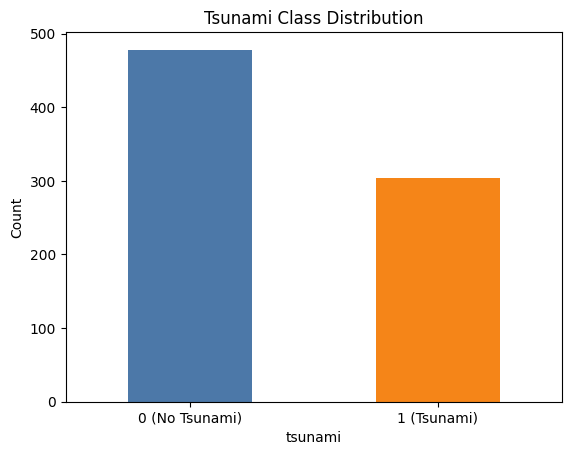

In [52]:
ax = data_df['tsunami'].value_counts().sort_index().plot(kind='bar', color=['#4c78a8', '#f58518'])
ax.set_xticklabels(['0 (No Tsunami)', '1 (Tsunami)'], rotation=0)
plt.title('Tsunami Class Distribution')
plt.ylabel('Count')
plt.xlabel('tsunami')
plt.show()

We will look at which features differ between classes. This helps prioritize features for deeper investigation.

In [53]:
num_cols = [c for c in data_df.columns if c != 'tsunami']

group_means = data_df.groupby('tsunami')[num_cols].mean().T
group_stds  = data_df.groupby('tsunami')[num_cols].std().T
delta = group_means[1] - group_means[0]
summary = pd.concat([group_means[0].rename('mean_0'),
                     group_means[1].rename('mean_1'),
                     delta.rename('mean_diff')], axis=1).round(3)

summary.reindex(summary['mean_diff'].abs().sort_values(ascending=False).index)

,mean_0,mean_1,mean_diff
nst,349.933,42.066,-307.867
longitude,65.461,32.401,-33.060
depth,69.667,85.657,15.989
sig,874.092,863.845,-10.247
Year,2009.134,2017.227,8.093
latitude,6.002,-0.335,-6.337
gap,22.792,28.571,5.779
dmin,0.617,2.440,1.823
cdi,3.929,4.970,1.042
mmi,6.136,5.694,-0.442


nst feature shows a significant difference between tsunami and non-tsunami events.

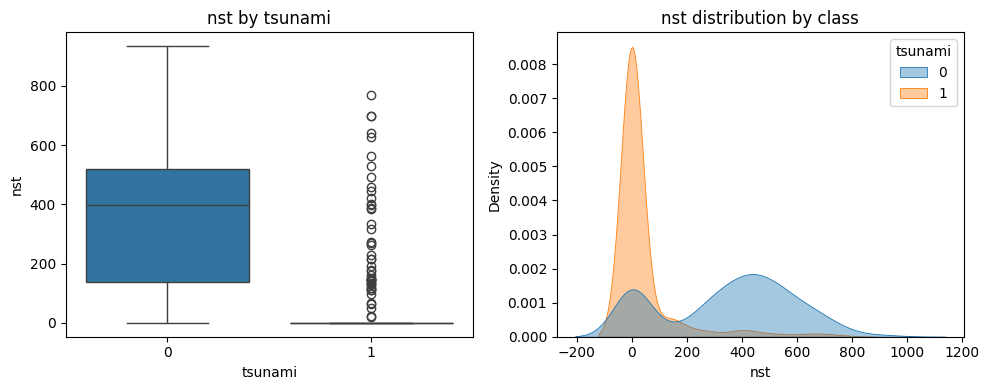

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(data=data_df, x='tsunami', y='nst', ax=ax[0])
ax[0].set_title('nst by tsunami'); ax[0].set_xlabel('tsunami'); ax[0].set_ylabel('nst')

sns.kdeplot(data=data_df, x='nst', hue='tsunami', common_norm=False, fill=True, alpha=0.4, linewidth=0.6, ax=ax[1])
ax[1].set_title('nst distribution by class'); ax[1].set_xlabel('nst')

plt.tight_layout()
plt.show()

we will visualize longitude distribution across tsunami classes because it has notable mean difference

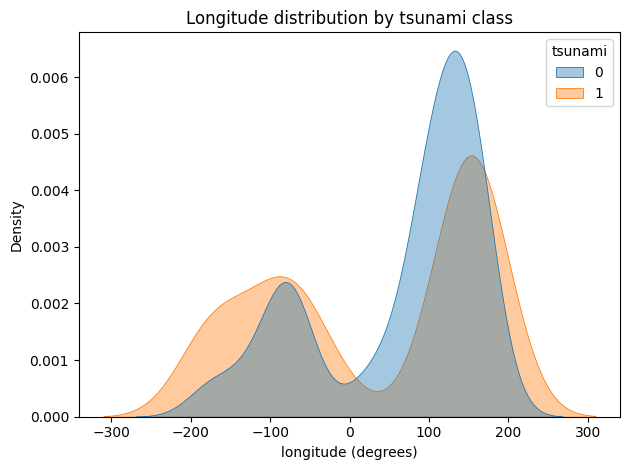

In [55]:
sns.kdeplot(data=data_df, x='longitude', hue='tsunami', common_norm=False, fill=True, alpha=0.4, linewidth=0.6)
plt.title('Longitude distribution by tsunami class')
plt.xlabel('longitude (degrees)')
plt.tight_layout()
plt.show()

While there's a notable mean difference longitude alone provides limited visual separation between classes. Now it is time to visualize depth distribution

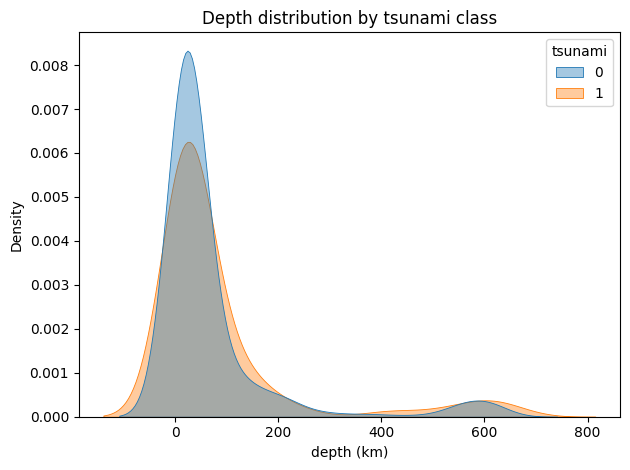

In [56]:
sns.kdeplot(data=data_df, x='depth', hue='tsunami', common_norm=False, fill=True, alpha=0.4, linewidth=0.6)
plt.title('Depth distribution by tsunami class')
plt.xlabel('depth (km)')
plt.tight_layout()
plt.show()

While there is a notable mean difference the distributions largely overlap

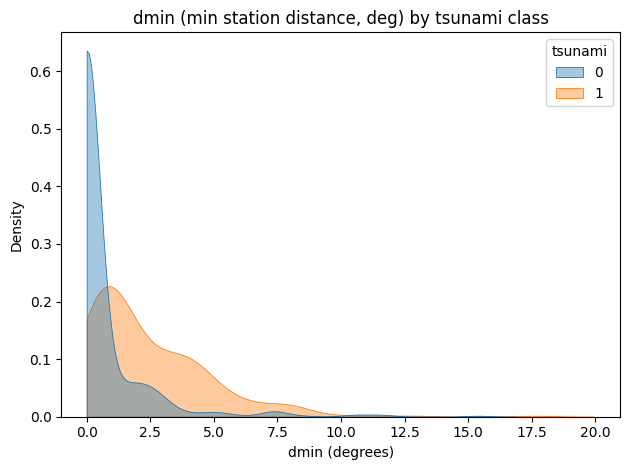

In [57]:
sns.kdeplot(data=data_df, x='dmin', hue='tsunami', common_norm=False, fill=True, alpha=0.4, linewidth=0.6, clip=(0, None))
plt.title('dmin (min station distance, deg) by tsunami class')
plt.xlabel('dmin (degrees)')
plt.tight_layout()
plt.show()

We looked at top 3 by absolute difference and found only nst has strong separation. We will continue with Correlation Heatmap

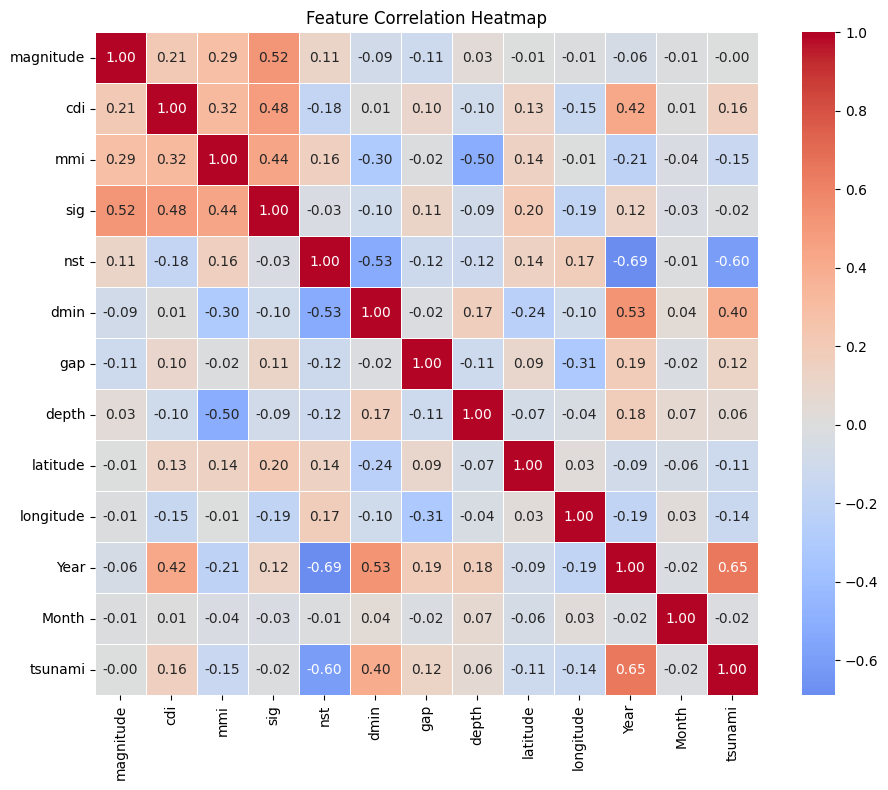

In [58]:
corr = data_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [59]:
corr['tsunami'].drop('tsunami').abs().sort_values(ascending=False).round(3)

Year         0.647
nst          0.600
dmin         0.401
cdi          0.160
mmi          0.147
longitude    0.137
gap          0.116
latitude     0.113
depth        0.057
Month        0.022
sig          0.015
magnitude    0.005
Name: tsunami, dtype: float64

Magnitude has almost zero correlation (0.005) with tsunami, this is surprising because we would expect larger earthquakes to be more likely to generate tsunamis. We will come back to that later

It is interesting. Tsunami is mostly correlated to year. It seems to be data collection artifact and should be excluded from modeling. Let's confirm this

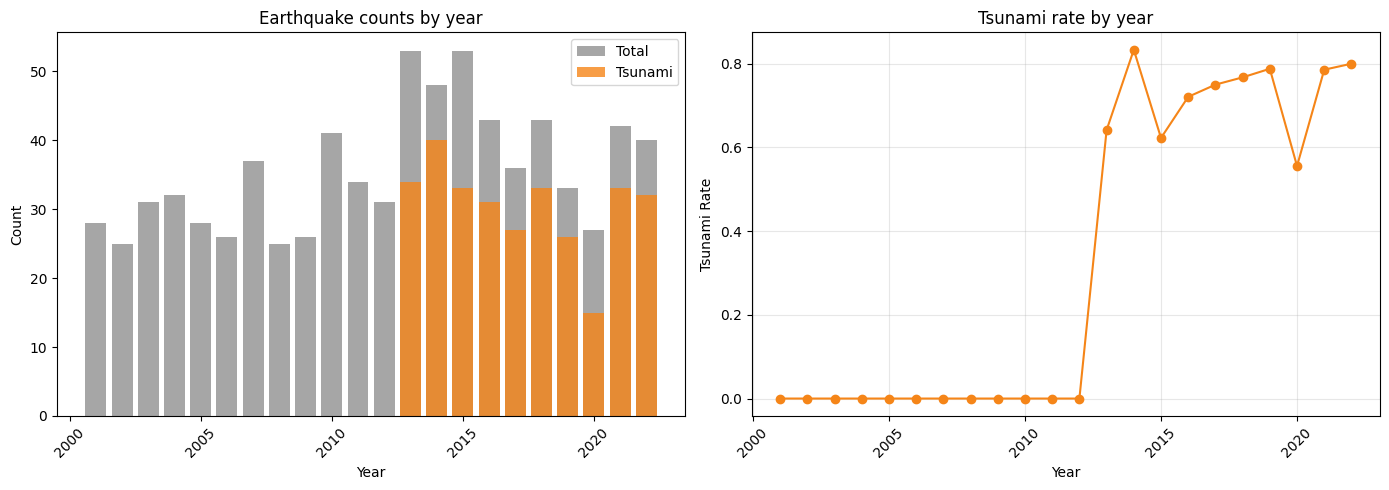

In [60]:
year_stats = data_df.groupby('Year').agg({
    'tsunami': ['sum', 'count', 'mean']
}).reset_index()
year_stats.columns = ['Year', 'tsunami_count', 'total_count', 'tsunami_rate']

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(year_stats['Year'], year_stats['total_count'], alpha=0.7, color='gray', label='Total')
ax[0].bar(year_stats['Year'], year_stats['tsunami_count'], alpha=0.8, color='#f58518', label='Tsunami')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].set_title('Earthquake counts by year')
ax[0].legend()
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(year_stats['Year'], year_stats['tsunami_rate'], marker='o', color='#f58518')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Tsunami Rate')
ax[1].set_title('Tsunami rate by year')
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

This is clearly a dataset construction artifact now we will visualise earthquake epicenters on a map to see if there is regional tsunami patterns.

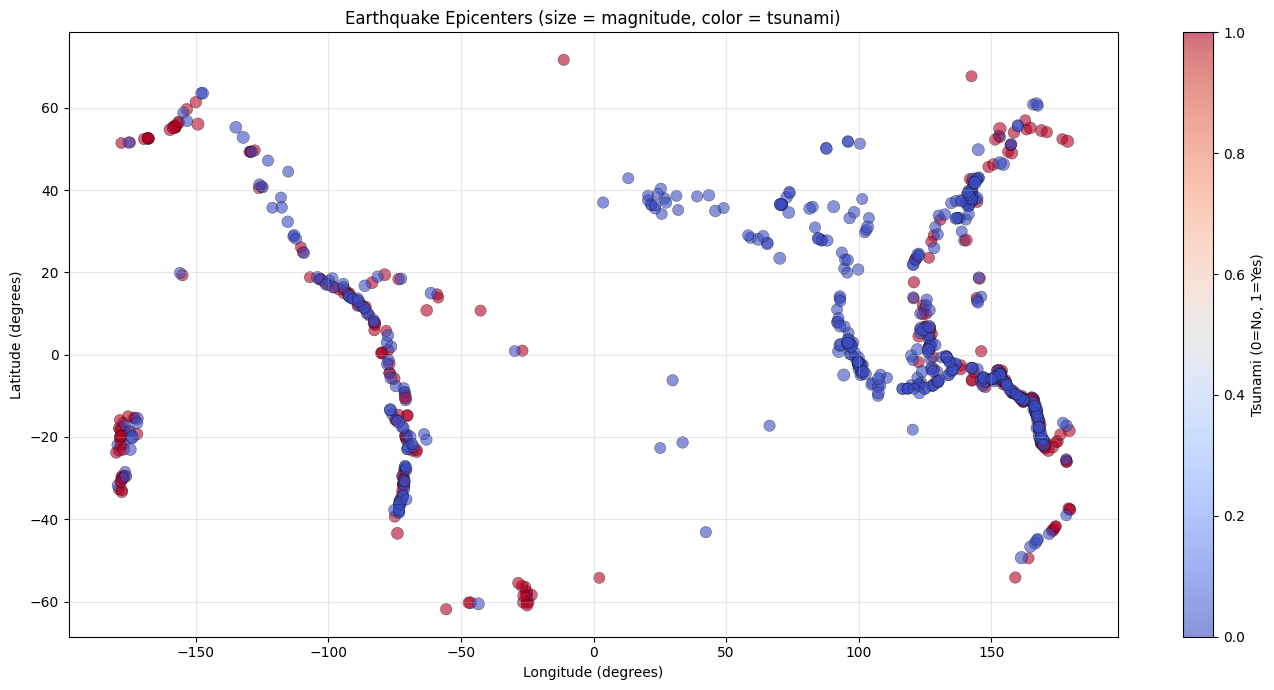

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
scatter = ax.scatter(data_df['longitude'], data_df['latitude'], 
                     c=data_df['tsunami'], cmap='coolwarm', 
                     s=data_df['magnitude']*10, alpha=0.6, edgecolors='black', linewidth=0.3)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.set_title('Earthquake Epicenters (size = magnitude, color = tsunami)')
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Tsunami (0=No, 1=Yes)')
plt.tight_layout()
plt.show()

In [62]:
fig = px.scatter_geo(
    data_df,
    lat='latitude',
    lon='longitude',
    color='tsunami',
    size='magnitude',
    hover_data=['magnitude', 'depth', 'Year', 'tsunami'],
    color_discrete_map={0: '#4c78a8', 1: '#f58518'},
    labels={'tsunami': 'Tsunami'},
    projection='natural earth',
    size_max=15
)

fig.update_layout(
    geo=dict(
        showland=True,
        landcolor='rgb(243, 243, 243)',
        coastlinecolor='rgb(204, 204, 204)',
        showocean=True,
        oceancolor='rgb(230, 245, 255)',
        showcountries=True,
        countrycolor='rgb(204, 204, 204)'
    ),
    height=600,
    width=1200
)

fig.show()

Tsunami risk is highest in oceanic subduction zones but even there not all earthquakes generate tsunamis

### This leads us to explore the relationship between the location of the earthquake (ocean or not) and whether it caused tsunami or not.

In [63]:
from helper.calculate_land import is_ocean
data_df['is_ocean'] = data_df.apply(lambda row: is_ocean(row['latitude'], row['longitude']), axis=1)
# save updated dataframe if needed
processed_data_path = Path("../data/processed/1/earthquake_data_tsunami_processed.csv")

data_df.to_csv(processed_data_path, index=False)
data_df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,is_ocean
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1,True
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0,True
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1,True
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1,True
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1,True


In [64]:
print("is_ocean distribution:")
print(data_df['is_ocean'].value_counts())
print("\nPercentage:")
print(data_df['is_ocean'].value_counts(normalize=True).mul(100).round(2))

print("\nTsunami vs is_ocean crosstab:")
crosstab = pd.crosstab(data_df['tsunami'], data_df['is_ocean'], margins=True)
print(crosstab)

print("\nTsunami rate by location:")
tsunami_rate = data_df.groupby('is_ocean')['tsunami'].agg(['sum', 'count', 'mean']).round(3)
tsunami_rate.columns = ['Tsunami Count', 'Total Events', 'Tsunami Rate']
tsunami_rate.index = ['Land (0)', 'Ocean (1)']
print(tsunami_rate)



is_ocean distribution:
is_ocean
True     603
False    179
Name: count, dtype: int64

Percentage:
is_ocean
True     77.11
False    22.89
Name: proportion, dtype: float64

Tsunami vs is_ocean crosstab:
is_ocean  False  True  All
tsunami                   
0           132   346  478
1            47   257  304
All         179   603  782

Tsunami rate by location:
           Tsunami Count  Total Events  Tsunami Rate
Land (0)              47           179         0.263
Ocean (1)            257           603         0.426


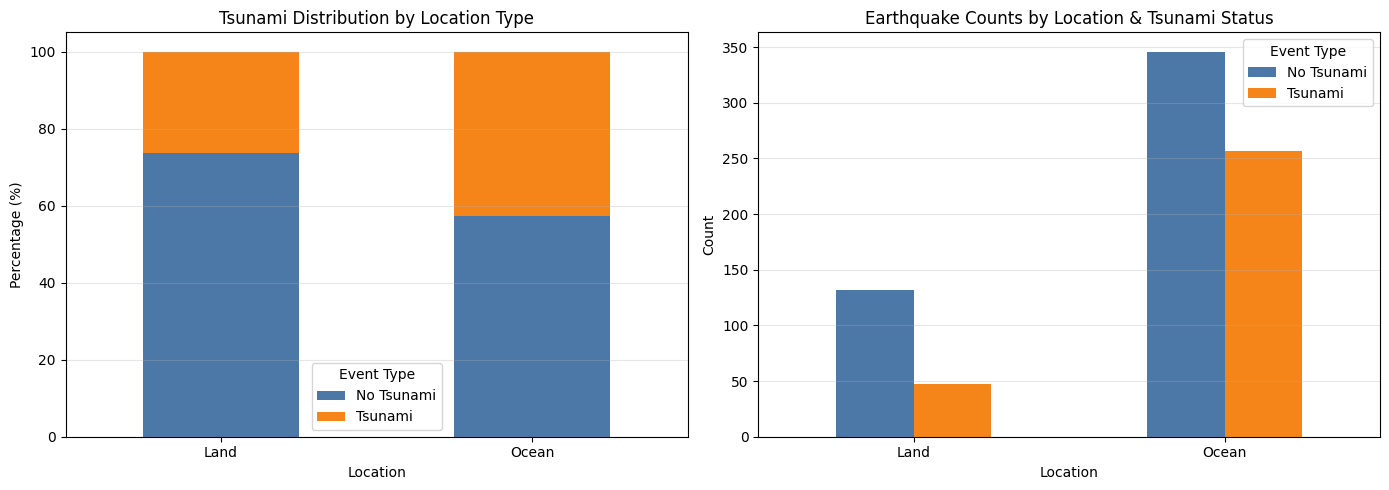

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Stacked bar chart
crosstab_plot = pd.crosstab(data_df['is_ocean'], data_df['tsunami'], normalize='index').mul(100)
crosstab_plot.plot(kind='bar', stacked=True, ax=axes[0], color=['#4c78a8', '#f58518'])
axes[0].set_xticklabels(['Land', 'Ocean'], rotation=0)
axes[0].set_ylabel('Percentage (%)')
axes[0].set_xlabel('Location')
axes[0].set_title('Tsunami Distribution by Location Type')
axes[0].legend(['No Tsunami', 'Tsunami'], title='Event Type')
axes[0].grid(alpha=0.3, axis='y')

# Right: Count comparison
crosstab_counts = pd.crosstab(data_df['is_ocean'], data_df['tsunami'])
crosstab_counts.plot(kind='bar', ax=axes[1], color=['#4c78a8', '#f58518'])
axes[1].set_xticklabels(['Land', 'Ocean'], rotation=0)
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Location')
axes[1].set_title('Earthquake Counts by Location & Tsunami Status')
axes[1].legend(['No Tsunami', 'Tsunami'], title='Event Type')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



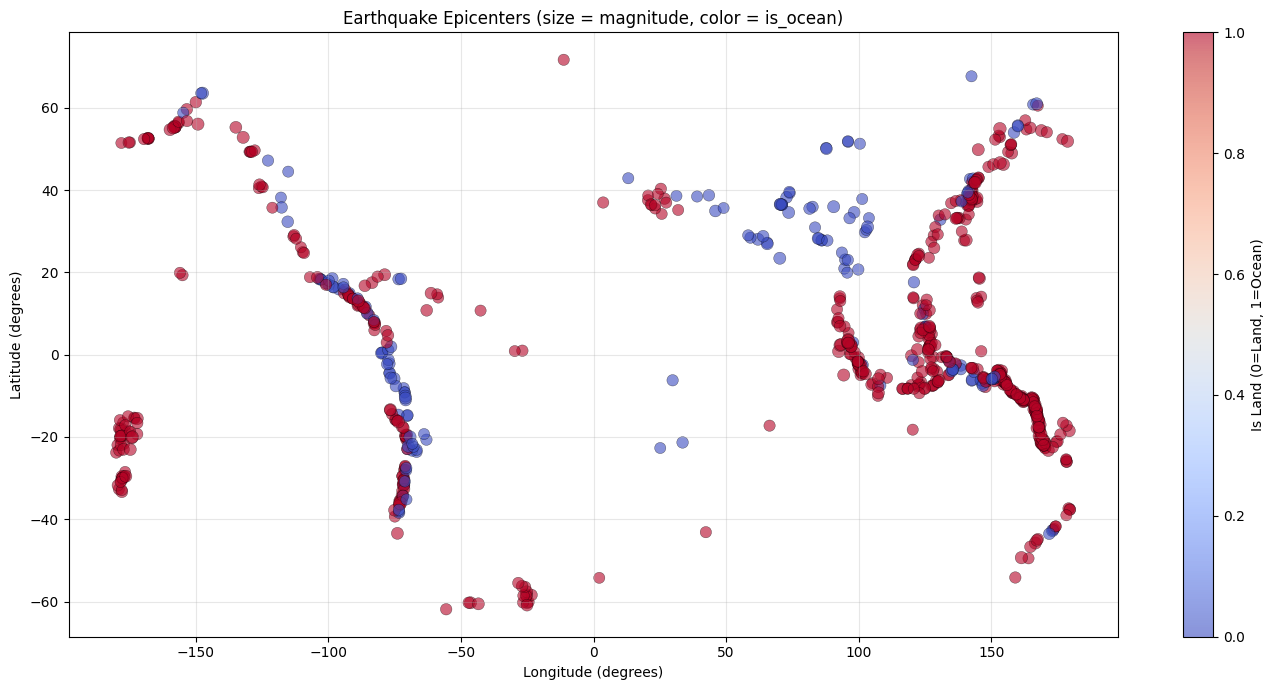

In [66]:

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
scatter = ax.scatter(data_df['longitude'], data_df['latitude'], 
                     c=data_df['is_ocean'], cmap='coolwarm', 
                     s=data_df['magnitude']*10, alpha=0.6, edgecolors='black', linewidth=0.3)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.set_title('Earthquake Epicenters (size = magnitude, color = is_ocean)')
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Is Land (0=Land, 1=Ocean)')
plt.tight_layout()
plt.show()

In [67]:

fig = px.scatter_geo(
    data_df,
    lat='latitude',
    lon='longitude',
    color='is_ocean',
    size='magnitude',
    hover_data=['magnitude', 'depth', 'Year', 'tsunami', 'is_ocean'],
    color_discrete_map={0: '#4c78a8', 1: '#f58518'},
    labels={'is_ocean': 'Location Type'},
    projection='natural earth',
    size_max=15,
    title='Earthquake Locations: Land vs Ocean'
)

fig.update_layout(
    geo=dict(
        showland=True,
        landcolor='rgb(243, 243, 243)',
        coastlinecolor='rgb(204, 204, 204)',
        showocean=True,
        oceancolor='rgb(230, 245, 255)',
        showcountries=True,
        countrycolor='rgb(204, 204, 204)'
    ),
    height=600,
    width=1200
)

fig.show()

We have talked about how surprising it is to magnitude is not correlated to tsunamis. Now we will investigate that. This weak correlation maybe suggest either:
* Magnitude doesnt really matter
* Nonlinear relationship
* Magnitude needs to interact with other features

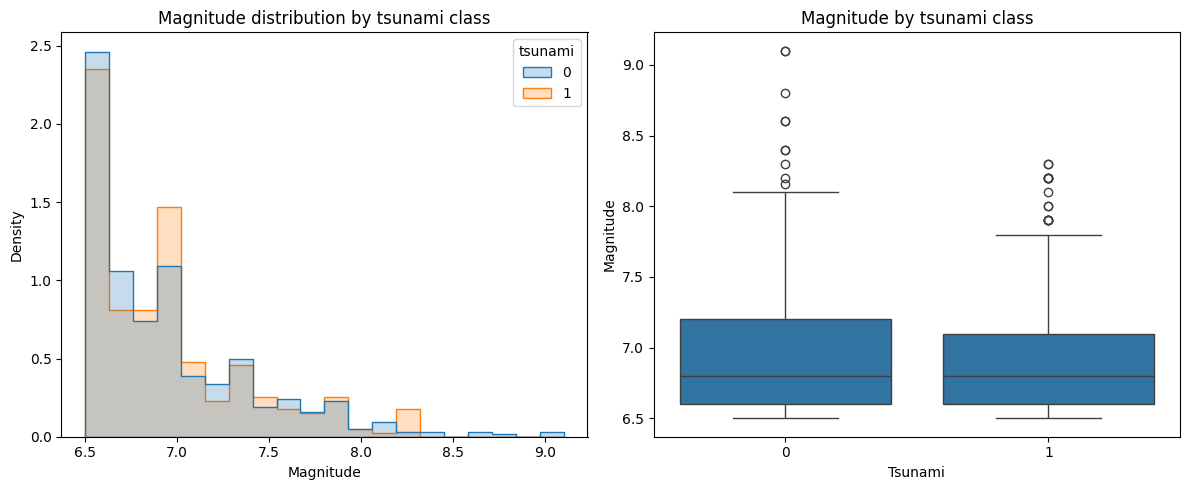

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=data_df, x='magnitude', hue='tsunami', element='step', stat='density', 
             common_norm=False, bins=20, ax=ax[0])
ax[0].set_title('Magnitude distribution by tsunami class')
ax[0].set_xlabel('Magnitude')
ax[0].set_ylabel('Density')

sns.boxplot(data=data_df, x='tsunami', y='magnitude', ax=ax[1])
ax[1].set_title('Magnitude by tsunami class')
ax[1].set_xlabel('Tsunami')
ax[1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()

In [69]:
data_df.groupby('tsunami')['magnitude'].describe().round(3)

,count,mean,std,min,25%,50%,75%,max
tsunami,,,,,,,,
0,478.0,6.943,0.460,6.5,6.6,6.8,7.2,9.1
1,304.0,6.938,0.423,6.5,6.6,6.8,7.1,8.3


Statistics almost identical. Magnitude alone is NOT a discriminating feature for tsunami prediction in this dataset. Maybe where and how deep it occurs that determines tsunami generation. Let's investigate if the combination of magnitude and depth reveals tsunami patterns.

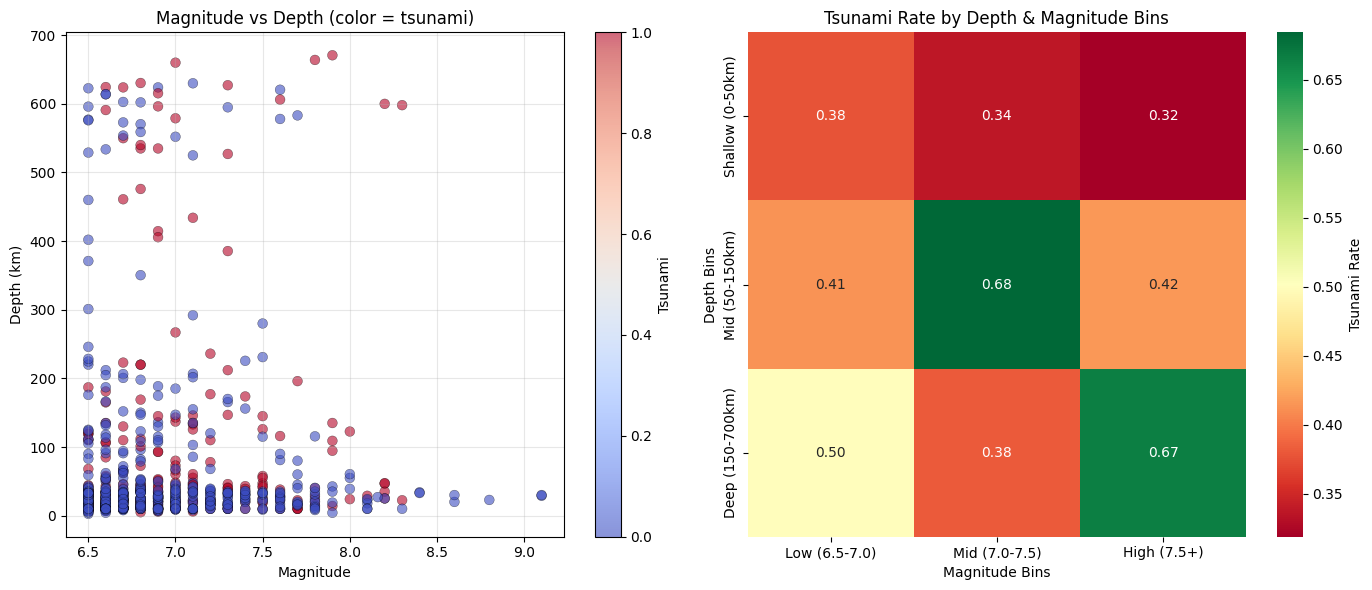

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

scatter = ax[0].scatter(data_df['magnitude'], data_df['depth'], 
                        c=data_df['tsunami'], cmap='coolwarm', 
                        s=50, alpha=0.6, edgecolors='black', linewidth=0.3)
ax[0].set_xlabel('Magnitude')
ax[0].set_ylabel('Depth (km)')
ax[0].set_title('Magnitude vs Depth (color = tsunami)')
ax[0].grid(alpha=0.3)
cbar0 = plt.colorbar(scatter, ax=ax[0])
cbar0.set_label('Tsunami')

data_df['depth_bin'] = pd.cut(data_df['depth'], bins=[0, 50, 150, 700], labels=['Shallow (0-50km)', 'Mid (50-150km)', 'Deep (150-700km)'])
data_df['mag_bin'] = pd.cut(data_df['magnitude'], bins=[6.5, 7.0, 7.5, 10], labels=['Low (6.5-7.0)', 'Mid (7.0-7.5)', 'High (7.5+)'])

pivot_table = data_df.pivot_table(values='tsunami', 
                                   index='depth_bin', 
                                   columns='mag_bin', 
                                   aggfunc='mean', 
                                   observed=True)
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax[1], cbar_kws={'label': 'Tsunami Rate'})
ax[1].set_title('Tsunami Rate by Depth & Magnitude Bins')
ax[1].set_xlabel('Magnitude Bins')
ax[1].set_ylabel('Depth Bins')

plt.tight_layout()
plt.show()

Scatter plot shows no clear linear separation but heatmap reveals some key interactions:
* Mid depth + Mid magnitude = %68 -> Highest Risk Zone 
* Deep + High magnitude = %67 -> Second Highest Risk Zone
* At shallow depths it relatively uniform
* Deep + Low magnitude = %50
Lets look at sample sizes of each combination

In [71]:
count_table = data_df.pivot_table(values='tsunami', 
                                  index='depth_bin', 
                                  columns='mag_bin', 
                                  aggfunc='count', 
                                  observed=True)
count_table

mag_bin,Low (6.5-7.0),Mid (7.0-7.5),High (7.5+)
depth_bin,,,
Shallow (0-50km),313,104,69
Mid (50-150km),58,19,12
Deep (150-700km),46,21,9


In [72]:
rate_table = data_df.pivot_table(values='tsunami', 
                                 index='depth_bin', 
                                 columns='mag_bin', 
                                 aggfunc=['mean', 'count'], 
                                 observed=True)
rate_table

mean                                   count  \
mag_bin          Low (6.5-7.0) Mid (7.0-7.5) High (7.5+) Low (6.5-7.0)   
depth_bin                                                                
Shallow (0-50km)      0.376997      0.336538    0.318841           313   
Mid (50-150km)        0.413793      0.684211    0.416667            58   
Deep (150-700km)      0.500000      0.380952    0.666667            46   

                                            
mag_bin          Mid (7.0-7.5) High (7.5+)  
depth_bin                                   
Shallow (0-50km)           104          69  
Mid (50-150km)              19          12  
Deep (150-700km)            21           9

* Mid depth + Mid magnitude = %68 -> n=19, small but notable
* Deep + High magnitude = %67 -> n=9, very small sample
* At shallow depths it relatively uniform -> large samples -> most reliable estimates
* Deep + Low magnitude = %50 -> n=46, moderate sample -> reasonably reliable
Magnitude depth interaction exists but is confounded by small sample sizes in some cells

In [73]:
data_df.groupby('depth_bin', observed=True)['tsunami'].agg(['mean', 'count']).round(3)

,mean,count
depth_bin,,
Shallow (0-50km),0.372,589
Mid (50-150km),0.461,102
Deep (150-700km),0.418,91


Magnitude alone doesnt matter, no monotonic relationship

In [74]:
data_df.groupby('mag_bin', observed=True)['tsunami'].agg(['mean', 'count']).round(3)

,mean,count
mag_bin,,
Low (6.5-7.0),0.396,417
Mid (7.0-7.5),0.389,144
High (7.5+),0.367,90


Slight variation, no monotonic relationship. So key takeaway is magnitude alone is insufficient, depth context matters. Now let's identify outliers that might affect model training.

In [75]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((series < lower) | (series > upper)).sum()
    return outliers, len(series), outliers / len(series) * 100

numeric_cols = ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude']
outlier_summary = []

for col in numeric_cols:
    n_outliers, n_total, pct = count_outliers(data_df[col])
    outlier_summary.append({
        'Feature': col,
        'Outliers': n_outliers,
        'Total': n_total,
        'Percent': round(pct, 2)
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Percent', ascending=False)
outlier_df

,Feature,Outliers,Total,Percent
7,depth,139,782,17.77
3,sig,73,782,9.34
5,dmin,61,782,7.80
6,gap,48,782,6.14
0,magnitude,37,782,4.73
2,mmi,1,782,0.13
1,cdi,0,782,0.00
4,nst,0,782,0.00
8,latitude,0,782,0.00
9,longitude,0,782,0.00


It seems there are many outliers in some features. That result need attention

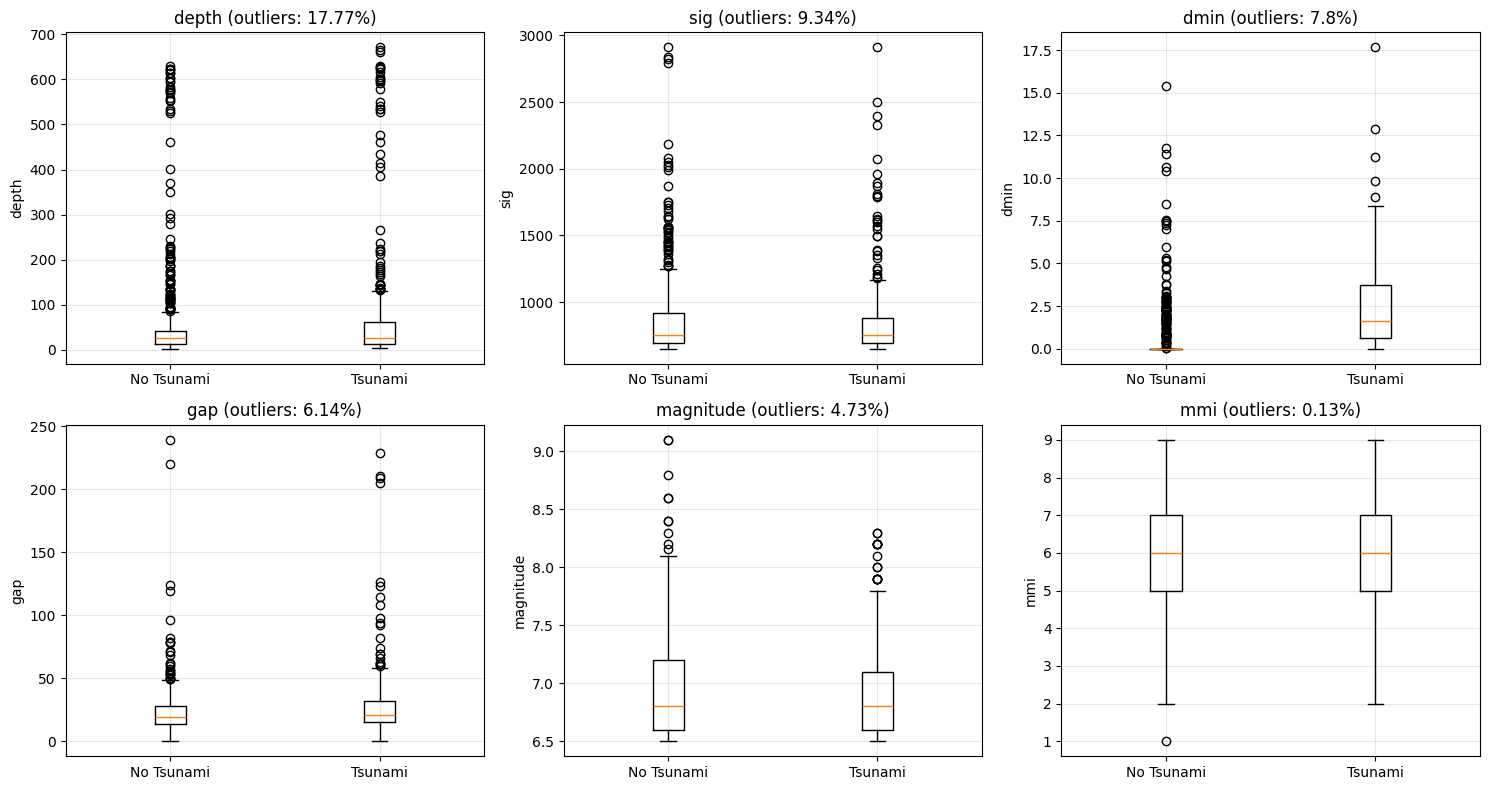

In [76]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
top_outlier_features = outlier_df.head(6)['Feature'].tolist()

for idx, col in enumerate(top_outlier_features):
    axes[idx].boxplot([data_df[data_df['tsunami']==0][col], 
                       data_df[data_df['tsunami']==1][col]], 
                      tick_labels=['No Tsunami', 'Tsunami'])
    axes[idx].set_title(f'{col} (outliers: {outlier_df[outlier_df["Feature"]==col]["Percent"].values[0]}%)')
    axes[idx].set_ylabel(col)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

There is an interesting point here. The median of Dmin when it is non-tsunami earthquakes is at 0, Almost all non-tsunami events are so close to stations and most data points are clustered near 0. 
Earthquakes that makes tsunami,  median is around 1.5-2 most tsunami earthquakes happen far from stations, events are spread out over a larger distance range and can happen at various distances from stations.

##### So If an earthquake is far from any station (dmin > 1), it's more likely to cause a tsunami. If it's very close to a station (dmin ≈ 0), it's less likely to cause a tsunami. 

Depth, dmin, and gap show outliers caused by real physical factors not data errors. These outliers should be retained but treated carefully. 

In [77]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Get correlation matrix (excluding Year and Month since we know they're artifacts)
# features_to_analyze = ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude']
# corr_matrix = data_df[features_to_analyze].corr()

# # Find high correlation pairs (>0.5)
# high_corr_pairs = []
# for i in range(len(corr_matrix.columns)):
#     for j in range(i+1, len(corr_matrix.columns)):
#         if abs(corr_matrix.iloc[i, j]) > 0.5:
#             high_corr_pairs.append({
#                 'Feature 1': corr_matrix.columns[i],
#                 'Feature 2': corr_matrix.columns[j],
#                 'Correlation': round(corr_matrix.iloc[i, j], 3)
#             })

# print("High correlation pairs (|r| > 0.5):")
# if high_corr_pairs:
#     high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', key=abs, ascending=False)
#     print(high_corr_df.to_string(index=False))
# else:
#     print("No high correlation pairs found")

# # Visualize correlation matrix
# plt.figure(figsize=(11, 9))
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
#             center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
# plt.title('Feature Correlation Matrix (excluding Year/Month)')
# plt.tight_layout()
# plt.show()